In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE

## Loading the StepFunc dataset

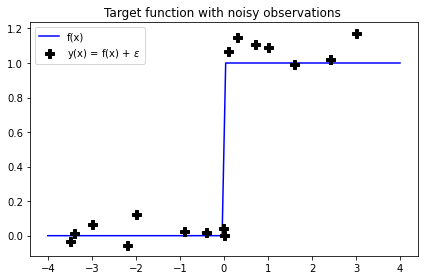

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Test inputs
num_test_samples = 100
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)

# Noise free training inputs
X_train = np.array([-3.5, -3.4, -3,-2.2, -2, -0.9,-0.4, -0.01,0,0.1, 0.3,0.7, 1, 1.6 , 2.4, 3.0]).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = np.heaviside(X_train, 0)

# Noise-free training outputs
#f = np.cos(X_test)
f = np.heaviside(X_test, 0)
y_test  = f

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.1

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"



X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}


In [38]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(self, input_dim=1, output_dim=1, width_seq=None, depth=None, device="cpu"):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = 20
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.output_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        for wx, wy in self.shapes[:-1]:
            x = F.linear(x, Θ[index: index + wx * wy].reshape(wy, wx))
            x = F.relu(x)
            index += wx * wy
        wx, wy = self.shapes[-1]
        x = F.linear(x, Θ[index: index + wx * wy].reshape(wy, wx))
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [53]:
net = OnedRegressionForwardNet(1,1, device=device, depth=1)

def ln_prior(Θ, σ_w=1.0):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2


def log_likelihood_vmap(Θ, X, y):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    preds_func = lambda θ: net.forward(X, θ)
#     batched_preds = torch._vmap_internals.vmap(preds_func)
#     import pdb; pdb.set_trace()
    preds = torch.hstack(list(map(preds_func, Θ)))

    diff = preds - y
#     import pdb; pdb.set_trace()
    diff_sq_fld = -0.5 * (diff**2).sum(dim=0)

    return diff_sq_fld

In [54]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = net.dim

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [42]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood_vmap, γ=1.0, device=device)


tensor(22367.8652, device='cuda:0', grad_fn=<MeanBackward0>)

In [43]:
γ = 1.0
Δt = 0.05
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300
# with torch.autograd.set_detect_anomaly(True):
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                ln_prior, log_likelihood_vmap, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            ln_prior, log_likelihood_vmap, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

20


  0%|          | 0/300 [00:00<?, ?it/s]

In [44]:
losses

[24739.6015625,
 27027.615234375,
 33593.35546875,
 16364.9296875,
 14405.125,
 16364.4833984375,
 7176.65869140625,
 4921.8203125,
 5507.8955078125,
 2113.597900390625,
 1218.291015625,
 1304.770751953125,
 1290.3924560546875,
 1184.1441650390625,
 977.6157836914062,
 1815.80908203125,
 800.7025756835938,
 937.7572631835938,
 1450.2176513671875,
 1213.7899169921875,
 1414.579833984375,
 759.930908203125,
 920.4129638671875,
 1197.72607421875,
 546.8817138671875,
 646.095947265625,
 575.649169921875,
 1522.361572265625,
 700.1598510742188,
 1679.2076416015625,
 692.2055053710938,
 575.9024658203125,
 2687.378173828125,
 614.2047729492188,
 737.844970703125,
 762.2476196289062,
 755.64794921875,
 613.1157836914062,
 627.1725463867188,
 489.7043762207031,
 711.8761596679688,
 651.157470703125,
 654.3921508789062,
 370.74560546875,
 429.35888671875,
 735.7849731445312,
 408.4146728515625,
 464.8758850097656,
 642.6671142578125,
 504.7452087402344,
 513.9291381835938,
 588.3475952148438,
 

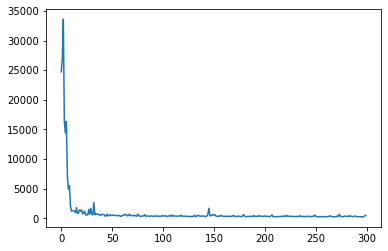

In [45]:
plt.plot(losses[:])

In [58]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 1.,  2.,  5.,  3., 11.,  6.,  8.,  9.,  2.,  3.]),
 array([-2.227136 , -1.7924598, -1.3577837, -0.9231076, -0.4884315,
        -0.0537554,  0.3809207,  0.8155968,  1.2502729,  1.684949 ,
         2.119625 ], dtype=float32),
 <a list of 10 Patch objects>)

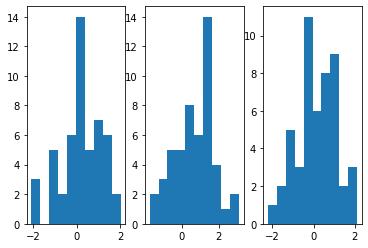

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [48]:
pred = net.map_forward(X_train, Θ_1).mean(axis=1)

C:\Users\vargf\AppData\Local\Temp/ipykernel_25680/557985267.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


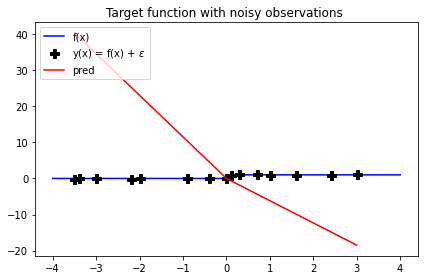

In [59]:


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [51]:
net.dim

840

In [66]:
# net = OnedRegressionForwardNet(1,1, device=device, depth=3)
net.shapes

[(1, 20), (20, 20), (20, 20), (20, 1)]

tensor([ 1.3155, -0.8297,  2.0207], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.1563,  0.8567, -1.1597], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.2566, 0.5845, 1.2754], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4038, -0.7700, -0.9377], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.7558, -0.0267,  0.0200], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.2502,  0.3860,  0.3810], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4093, -0.8089,  2.3301], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-1.3416, -1.4051,  1.6230], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5422,  1.0885, -0.6465], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.5966, -1.0273,  1.4588], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.7769, -1.5714, -0.3028], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([1.2878, 0.2816, 0.2564], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4549,  0.8052, -1.6720], device='cuda:0', grad_

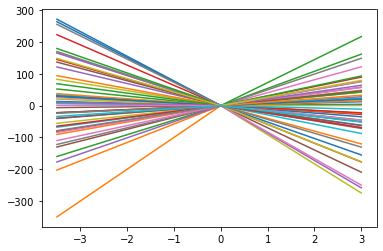

In [60]:
for i in range(len(Θ_1)):
    print(Θ_1[i,:3])
    pred = net.forward(X_train, Θ_1[i,:,]).mean(axis=1)
    plt.plot(X_train.detach().cpu(), pred.detach().cpu())
# plt.plot(X_train.detach().cpu(), y_train.detach().cpu())

In [143]:
Θ_1.mean(axis=0)

tensor([-0.7801, -0.1084,  0.1080, -0.2544,  0.3704,  0.1321,  0.1566, -0.3178,
        -0.2910,  0.3771, -0.3265, -0.3465, -0.1539,  0.1084, -0.1494, -0.0304,
        -0.1860,  0.0646, -0.3617,  0.4300, -1.4132, -0.8205, -0.6709, -0.9085,
        -0.6943, -0.8013, -1.1529, -1.2076, -1.2691, -0.8796, -0.8362, -0.5513,
        -0.8389, -1.0300, -1.0318, -1.0042, -0.7326, -1.1254, -0.8379, -0.9494,
        -0.7875, -1.0230, -1.0562, -0.8678, -0.9215, -0.8175, -0.7790, -1.4147,
        -0.9507, -0.7103, -0.6839, -0.7546, -0.6335, -0.3720, -0.6373, -1.2080,
        -1.0128, -1.0070, -0.9353, -1.6048, -0.5986, -0.9645, -0.3699, -0.8701,
        -0.8113, -0.7402, -0.6355, -1.0007, -0.9172, -0.5589, -0.4833, -0.4535,
        -0.6348, -0.6818, -0.4651, -0.7502, -0.7177, -0.5938, -0.5395, -0.8373,
        -1.2992, -1.2083, -0.6627, -0.8179, -0.7179, -1.1380, -0.4860, -0.9471,
        -0.4967, -0.5418, -0.7372, -0.7034, -0.8282, -1.0916, -0.6223, -0.7912,
        -0.7844, -0.6386, -0.9753, -0.58

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [25]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train + gaussian_prior(Θ_map)))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        losses_map.append(loss.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_27535/3526744317.py:27: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


(tensor(0.9875, device='cuda:0'),
 tensor([[ 0.0000, -2.1514,  2.0305]], device='cuda:0', requires_grad=True))

## Pyro Bayesian Logistic Regeression

As a baseline we run pyro with SVI on this same example atm we get very different results which is a bit worrying.

#### EDIT:

I think results are actually in agreement what was happening is the priors in the pyro code where much more confident thus the smaller weights. I just tried changing the prior of this pyro model and the posterior is not changing much, this is a bit fishy maybe worth investigating. 

I think it might just be the case that this model is not very good.

In [ ]:
import numpy as np
import scipy.special as ssp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

pyro.enable_validation(True)
torch.set_default_dtype(torch.double) # this was necessary on the CPU

In [ ]:

# these were adapted from the Pyro VAE tutorial

def train(svi, train_loader, n_train):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(*xs)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(*xs)

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker='o', label='Train ELBO')
    plt.plot(x[::test_int], test_elbo, marker='o', label='Test ELBO')
    plt.xlabel('Training Epoch')
    plt.legend()
    plt.show()

In [ ]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()
        
        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 0.0001 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale =  0.0001 * torch.ones(1)
        
        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight", dist.Normal(self.alpha_h_loc, self.alpha_h_scale, validate_args=True).independent(1)
        ).float()
        b = pyro.sample(
            "bias", dist.Normal(self.beta_h_loc, self.beta_h_scale, validate_args=True).independent(1)
        ).float()

        with pyro.iarange("data", x.size(0)):
#             import pdb; pdb.set_trace()
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()
            
            pyro.sample(
                "obs", 
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze()
            )
            
    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)

        pyro.sample(
            "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )
    
    
    def guide_(self, x, y, N=100):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)
        w = []
        b = []
        for _ in range(N):
            w.append(torch.tensor(pyro.sample(
                "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
            )))
            b.append(torch.tensor(pyro.sample(
                "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
            )))
#         import pdb;pdb.set_trace()
        return torch.vstack(w), torch.vstack(b)

In [ ]:

pyro.clear_param_store()

optim = Adam({'lr': 0.01})

num_epochs = 1000
batch_size = 50

N = X.shape[0]
p = 2

n_train = X_train.shape[0]
example_indices = np.random.permutation(N)
n_test = N - n_train
test_iter = 50

In [ ]:
lr_model = LogRegressionModel(p=p)

svi = SVI(
    lr_model.model, lr_model.guide, optim,
    loss=Trace_ELBO()
)


lr_dataset = torch.utils.data.TensorDataset(torch.tensor(X[:,1:]).float(), torch.tensor(y.reshape(-1,1)).float())

data_loader_train = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
)
    
data_loader_test = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
)

train_elbo = []
test_elbo = []
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, data_loader_train, n_train)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test)
        test_elbo.append(-total_epoch_loss_test)

In [ ]:
plot_llk(train_elbo, test_elbo, test_iter)

In [ ]:
W, b = lr_model.guide_(X_train.float(), y_train.float())

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

# ax1.hist(Θ_1[:,0].detach().numpy())
# ax2.hist(Θ_1[:,1].detach().numpy())
# ax3.hist(Θ_1[:,2].detach().numpy())


ax1.hist(b.detach().numpy(), color="red")
ax2.hist(W[:,0].detach().numpy(), color="red")
ax3.hist(W[:,1].detach().numpy(), color="red")


In [ ]:
b.mean(), W.mean(axis=0)